In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from nn import Layer, MLP, Neuron
from engine import Value

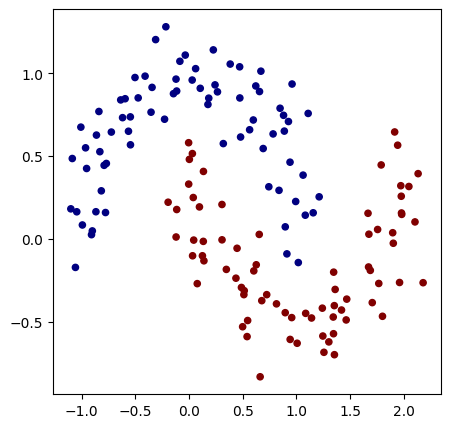

In [2]:
# make up a dataset
from sklearn.datasets import make_moons, make_blobs
X, y = make_moons(n_samples=150, noise=0.15)

y = y*2 - 1 # make y be -1 or 1
# visualize in 2D
plt.figure(figsize=(5,5))
plt.scatter(X[:,0], X[:,1], c=y, s=20, cmap='jet')

In [20]:
nouts = [(16, 'relu'), (16, 'relu'), (1, 'sigmoid')]
num_out_nodes = [layer[0] for layer in nouts]
activations = [layer[1] for layer in nouts]
print(num_out_nodes)
print(activations)
[2]+num_out_nodes

[16, 16, 1]
['relu', 'relu', 'sigmoid']


[2, 16, 16, 1]

In [3]:
# initialize a model 
model = MLP(2, [(16, 'relu'), (16, 'relu'), (1, 'sigmoid')]) # 2-layer neural network
print(model)
print("number of parameters", len(model.parameters()))

MLP of [Layer of [reluNeuron(2), reluNeuron(2), reluNeuron(2), reluNeuron(2), reluNeuron(2), reluNeuron(2), reluNeuron(2), reluNeuron(2), reluNeuron(2), reluNeuron(2), reluNeuron(2), reluNeuron(2), reluNeuron(2), reluNeuron(2), reluNeuron(2), reluNeuron(2)], Layer of [reluNeuron(16), reluNeuron(16), reluNeuron(16), reluNeuron(16), reluNeuron(16), reluNeuron(16), reluNeuron(16), reluNeuron(16), reluNeuron(16), reluNeuron(16), reluNeuron(16), reluNeuron(16), reluNeuron(16), reluNeuron(16), reluNeuron(16), reluNeuron(16)], Layer of [sigmoidNeuron(16)]]
number of parameters 337


In [4]:
X.shape

(150, 2)

In [ ]:
ri = np.random.permutation(X.shape[0])[:50]
xb = X[ri]

(50, 2)

In [11]:
# loss function
def loss(batch_size=None):
    
    # inline DataLoader :)
    if batch_size is None:
        Xb, yb = X, y
    else:
        ri = np.random.permutation(X.shape[0])[:batch_size]
        Xb, yb = X[ri], y[ri]
    inputs = [list(map(Value, xrow)) for xrow in Xb]
    
    # forward the model to get scores
    scores = list(map(model, inputs))
    
    # svm "max-margin" loss
    losses = [(1 + -yi*scorei).relu() for yi, scorei in zip(yb, scores)]
    data_loss = sum(losses) * (1.0 / len(losses))
    # L2 regularization
    alpha = 1e-4
    reg_loss = alpha * sum((p*p for p in model.parameters()))
    total_loss = data_loss + reg_loss
    
    # also get accuracy
    accuracy = [(yi > 0) == (scorei.data > 0) for yi, scorei in zip(yb, scores)]
    return total_loss, sum(accuracy) / len(accuracy)

total_loss, acc = loss()
print(total_loss, acc)

Value(data = 1.7563136620134796, grad = 0.0) 0.30666666666666664


In [12]:
# optimization
for k in range(50):
    
    # forward
    total_loss, acc = loss()
    
    # backward
    model.zero_grad()
    total_loss.backwards()
    
    # update (sgd)
    learning_rate = 1.0 - 0.9*k/100
    for p in model.parameters():
        p.data -= learning_rate * p.grad
    
    if k % 1 == 0:
        print(f"step {k} loss {total_loss.data}, accuracy {acc*100}%")

step 0 loss 1.7563136620134796, accuracy 30.666666666666664%
step 1 loss 0.9057578541510455, accuracy 73.33333333333333%
step 2 loss 3.2906016539043104, accuracy 50.0%
step 3 loss 0.6170129904171383, accuracy 70.66666666666667%
step 4 loss 0.752342775047915, accuracy 65.33333333333333%
step 5 loss 0.6208008025116563, accuracy 79.33333333333333%
step 6 loss 0.3226119035000644, accuracy 88.0%
step 7 loss 0.2861274098467013, accuracy 89.33333333333333%
step 8 loss 0.2534568583061978, accuracy 90.66666666666666%
step 9 loss 0.2611135925041827, accuracy 90.0%
step 10 loss 0.289131384772521, accuracy 89.33333333333333%
step 11 loss 0.20867418351543976, accuracy 92.66666666666666%
step 12 loss 0.21305947375669212, accuracy 93.33333333333333%
step 13 loss 0.18445291007819214, accuracy 94.66666666666667%
step 14 loss 0.18602125560277305, accuracy 94.0%
step 15 loss 0.1591848660039873, accuracy 95.33333333333334%
step 16 loss 0.17429906893639577, accuracy 94.0%
step 17 loss 0.19587123037621443, 

(-1.692844349523904, 2.057155650476096)

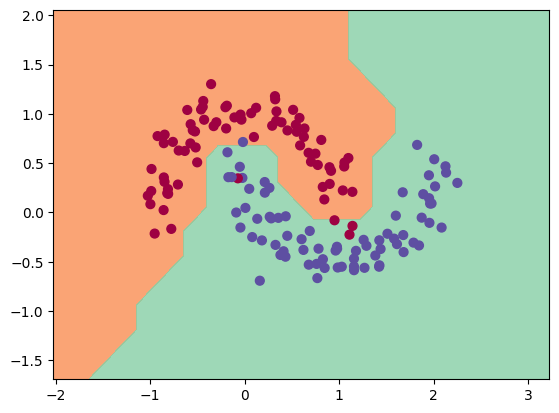

In [13]:
# visualize decision boundary

h = 0.25
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Xmesh = np.c_[xx.ravel(), yy.ravel()]
inputs = [list(map(Value, xrow)) for xrow in Xmesh]
scores = list(map(model, inputs))
Z = np.array([s.data > 0 for s in scores])
Z = Z.reshape(xx.shape)

fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())